In [1]:
import datetime
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ipywidgets
import pickle
import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import optuna
from optuna.integration import lightgbm as lgb
import tensorflow as tf

In [ ]:
pred_rf = pd.read_csv('submit/submit_RF22_2244.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost17_1208.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id, 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [ ]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(10)id

In [ ]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [ ]:
pred['pred'] = (pred.RandomForest * 0.04 + pred.XGBoost * 0.03 + pred.NN * 0.03
                + pred.LightGBM * 0.35 + pred.CatBoost * 0.55)
pred.head()

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred['id'],
    'pred':pred['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

# LogisticRegression

In [2]:
train_df = pd.read_csv('dataset/train_16_0246.csv')
test_df = pd.read_csv('dataset/test_16_0246.csv')

In [3]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])
y = train_df['y']

In [4]:
rf_model = pickle.load(open('models/RF_22_2248.pkl', 'rb'))
xgb_model = pickle.load(open('models/XG_17_1144.pkl', 'rb'))
lgb_model = pickle.load(open('models/LGBM_op24_0418.pkl', 'rb'))

In [5]:
f_rf = rf_model.predict_proba(x)
first_rf = pd.DataFrame(f_rf)

f_xgb = xgb_model.predict_proba(x)
first_xgb = pd.DataFrame(f_xgb)

f_lgb = lgb_model.predict(x)
first_lgb = pd.DataFrame(f_lgb)

first_pred = np.column_stack((first_rf[1],first_xgb[1], first_lgb[0]))
train_pred = pd.DataFrame(first_pred, columns=('RF', 'XGB', 'LGB'))

train_pred = pd.concat([ID, train_pred, y], axis=1)
train_pred['id'] = [int(i) for i in train_pred['id']]
train_pred.head(-10)

,id,RF,XGB,LGB,y
0,0,0.019764,0.000207,0.041840,0
1,1,0.178051,0.845551,0.178831,1
2,2,0.010521,0.000607,0.036251,0
3,3,0.014289,0.000238,0.040736,0
4,4,0.186455,0.004137,0.118117,0
...,...,...,...,...,...
27085,27085,0.025268,0.000278,0.046788,0
27086,27086,0.023498,0.000030,0.041830,0
27087,27087,0.044049,0.002026,0.051748,0
27088,27088,0.141111,0.091323,0.114841,0


In [6]:
del train_df, test_df, ID, x, y

In [7]:
train_df = pd.read_csv('dataset/train_cat_16_2206.csv')
test_df = pd.read_csv('dataset/test_cat_16_2206.csv')

In [8]:
ID = train_df['id']
x = train_df.drop(columns=['y', 'id'])

In [9]:
cb_model = pickle.load(open('models/CatBoost_24_0835.pkl', 'rb'))

In [10]:
f_cb = cb_model.predict_proba(x)
first_cb = pd.DataFrame(f_cb)

tmp_train_pred = pd.concat([ID, first_cb[1]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,1
0,0,0.005982
1,1,0.174154
2,2,0.006766
3,3,0.004269
4,4,0.148330
...,...,...
27085,27085,0.011141
27086,27086,0.003571
27087,27087,0.017806
27088,27088,0.182574


In [11]:
tr_pred = pd.merge(train_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={1: 'CB'})

In [12]:
"""
NNモデル追加
"""

'\nNNモデル追加\n'

In [13]:
del train_df, test_df, x, ID, tmp_train_pred
gc.collect()

90

In [14]:
train_df = pd.read_csv('dataset/train_nn17_1435.csv')
test_df = pd.read_csv('dataset/test_nn17_1435.csv')

In [15]:
ID = train_df['id']
x = train_df.drop(columns=['id', 'y'])

In [16]:
nn_model = tf.keras.models.load_model('models/nn_model_0.8250201.h5', compile=False)

In [17]:
nn_pred = nn_model.predict(x)
first_nn = pd.DataFrame(nn_pred)

tmp_train_pred = pd.concat([ID, first_nn[0]], axis=1)
tmp_train_pred['id'] = [int(i) for i in tmp_train_pred['id']]
tmp_train_pred.head(-10)

,id,0
0,0,0.003727
1,1,0.105578
2,2,0.004983
3,3,0.010434
4,4,0.110732
...,...,...
27085,27085,0.025660
27086,27086,0.009491
27087,27087,0.025590
27088,27088,0.151165


In [18]:
tr_pred = pd.merge(tr_pred, tmp_train_pred, on='id')
tr_pred = tr_pred.rename(columns={0: 'NN'})

In [19]:
col = ['id', 'RF', 'XGB', 'LGB', 'CB', 'NN', 'y']
tr_pred = tr_pred.reindex(col, axis=1)

del col
tr_pred.head(-10)

,id,RF,XGB,LGB,CB,NN,y
0,0,0.019764,0.000207,0.041840,0.005982,0.003727,0
1,1,0.178051,0.845551,0.178831,0.174154,0.105578,1
2,2,0.010521,0.000607,0.036251,0.006766,0.004983,0
3,3,0.014289,0.000238,0.040736,0.004269,0.010434,0
4,4,0.186455,0.004137,0.118117,0.148330,0.110732,0
...,...,...,...,...,...,...,...
27085,27085,0.025268,0.000278,0.046788,0.011141,0.025660,0
27086,27086,0.023498,0.000030,0.041830,0.003571,0.009491,0
27087,27087,0.044049,0.002026,0.051748,0.017806,0.025590,0
27088,27088,0.141111,0.091323,0.114841,0.182574,0.151165,0


In [20]:
del train_df, test_df, ID, x, tmp_train_pred
gc.collect()

726

In [21]:
x = tr_pred.iloc[:, 1:6]
y = tr_pred['y']
ID = tr_pred['id']

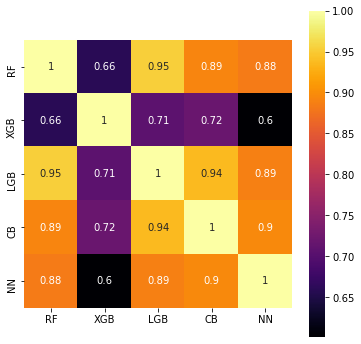

In [22]:
corr = x.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [23]:
"""
model tuning
"""

'\nmodel tuning\n'

In [24]:
def objective_lreg(trial):
    
    param_lreg = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e+5)
    }
    
    lreg = LogisticRegression(**param_lreg, max_iter=1000, random_state=18)
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=18)
    
    scoring = 'roc_auc'
    cv_output = cross_validate(lreg, x, y, n_jobs=-1, scoring=scoring, cv=skf)
    
    return cv_output['test_score'].mean()

In [25]:
%%time

study_lreg = optuna.create_study(direction='maximize')
study_lreg.optimize(objective_lreg, n_trials=300, n_jobs=-1)

lreg_best_params = study_lreg.best_params

[I 2020-08-26 10:40:51,444] Finished trial#4 resulted in value: 0.9725510056109826. Current best value is 0.9725510056109826 with parameters: {'C': 0.0020393043152879134}.
[I 2020-08-26 10:40:51,616] Finished trial#0 resulted in value: 0.9723317231658111. Current best value is 0.9725510056109826 with parameters: {'C': 0.0020393043152879134}.
[I 2020-08-26 10:40:51,695] Finished trial#2 resulted in value: 0.9727051888730349. Current best value is 0.9727051888730349 with parameters: {'C': 0.008369612374772743}.
[I 2020-08-26 10:40:52,550] Finished trial#5 resulted in value: 0.9662826258391141. Current best value is 0.9727051888730349 with parameters: {'C': 0.008369612374772743}.
[I 2020-08-26 10:40:52,551] Finished trial#1 resulted in value: 0.966281390655654. Current best value is 0.9727051888730349 with parameters: {'C': 0.008369612374772743}.
[I 2020-08-26 10:40:52,674] Finished trial#3 resulted in value: 0.9663064171824093. Current best value is 0.9727051888730349 with parameters: {'

CPU times: user 3min 13s, sys: 3min 16s, total: 6min 30s
Wall time: 1min 17s


In [26]:
print(study_lreg.best_params)
print('auc:', study_lreg.best_value)

{'C': 0.009517918900449424}
auc: 0.9727092538137437


In [ ]:
lreg_best_params = {
        'C': 0.009771875742604573
}

In [ ]:
lreg_model = LogisticRegression(**lreg_best_params, max_iter=1000, random_state=18)
lreg_model.fit(x, y)

In [ ]:
lreg_p = lreg_model.predict_proba(x)
p_lreg = pd.DataFrame(lreg_p)

lreg_pred = pd.DataFrame({
    'id':ID,
    'lreg': p_lreg[1]
})

In [ ]:
train_pred_df = pd.merge(tr_pred, lreg_pred, on='id')
train_pred_df.head(-10)

# PREDICT

In [ ]:
pred_rf = pd.read_csv('submit/submit_RF22_2244.csv', names=('id', 'RandomForest'))
pred_xgb = pd.read_csv('submit/submit_XGBoost17_1208.csv', names=('id', 'XGBoost'))
pred_lgb = pd.read_csv('submit/submit_LGBM24_0416.csv', names=('id', 'LightGBM'))
pred_cb = pd.read_csv('submit/submit_CatBoost24_0350.csv', names=('id', 'CatBoost'))
pred_nn = pd.read_csv('submit/submit_NN17_1648.csv', names=('id', 'NN'))

In [ ]:
pred = pd.merge(pred_rf, pred_xgb, on='id')
pred = pd.merge(pred, pred_lgb, on='id')
pred = pd.merge(pred, pred_cb, on='id')
pred = pd.merge(pred, pred_nn, on='id')
pred.head(-10)

In [ ]:
corr = pred.corr()

plt.subplots(figsize=(6,6))
sns.heatmap(corr, annot=True, square=True, cmap='inferno')

In [ ]:
del x, y, lreg_p, lreg_pred, p_lreg
gc.collect()

In [ ]:
x = pred.iloc[:, 1:]
ID = pred['id']

In [ ]:
lreg_p = lreg_model.predict_proba(x)
p_lreg = pd.DataFrame(lreg_p)

lreg_pred = pd.DataFrame({
    'id':ID,
    'lreg': p_lreg[1]
})

In [ ]:
pred_df = pd.merge(pred, lreg_pred, on='id')
pred_df.head(-10)

In [ ]:
pred_df['pred'] = (pred_df.RandomForest * 0.03 + pred_df.XGBoost * 0.02 + pred_df.NN * 0.02
                + pred_df.LightGBM * 0.3 + pred_df.CatBoost * 0.6 + pred_df.lreg * 0.05)
pred_df.head(-10)

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred_df['id'],
    'pred':pred_df['pred']
})

file_name = 'submit/submit_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)

In [ ]:
now = datetime.datetime.now()

submission = pd.DataFrame({
    'ID':pred_df['id'],
    'pred':pred_df['lreg']
})

file_name = 'submit/submit_lreg_' + now.strftime('%d_%H%M') + '.csv'

submission.to_csv(file_name, header=False, index=False)